# Analysis of Player performance in regards to chance of victory.

First, our import statements

In [1]:
from dotenv import load_dotenv
import requests
import os
import json
import mysql.connector
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

Next, lets setup our DB connection using a .env file.

In [2]:
%load_ext dotenv
%dotenv

mydb = mysql.connector.connect(
    host = os.getenv('CRUC_DB_HOST'),
    user = os.getenv('CRUC_DB_USER'),
    passwd = os.getenv('CRUC_DB_PASSWD'),
    database = os.getenv('CRUC_DATABASE'),
    auth_plugin='mysql_native_password',
    pool_name='crucible_pool',
    pool_size=5
)
mycursor = mydb.cursor()

Now, let's grab the data and store it in a dataframe.  Since there are 6 people per game this dataset covers over 300 games.

In [3]:
# get first 1000 rows from DB.
sql = f'SELECT `kills`, `deaths`, `assists`, `duration`, `completed`, `standing` FROM `survival_matches` ORDER BY `period` LIMIT 2000;'
mycursor.execute(sql)
sqlreturn = mycursor.fetchall()
mydb.close()

# convert to DF 
df = pd.DataFrame(sqlreturn, columns = ['kills', 'deaths', 'assists', 'duration', 'completed', 'standing'])
df.head()

,kills,deaths,assists,duration,completed,standing
0,16,11,1,754,1,1
1,9,14,4,754,1,0
2,12,11,1,754,1,0
3,8,13,6,754,1,1
4,19,13,2,754,1,0


We need to remove outliers where completed does not equal 1 (completed) and where standing does not equal 0 or 1 (win/loss).  Let's also drop any data where a player has no kills or deaths.  After this, we can drop the completed column as it is no longer needed.

In [4]:
df = df[df.completed == 1]
df = df[df.standing != 3]
df = df[(df.kills != 0) & (df.deaths != 0)]
df = df.drop(['completed'], 1)
df = df.reset_index(drop=True)

Now let's create a second df to analyse each stat per minute

In [5]:
minutes_df = df.copy()
minutes_df['kills'] = minutes_df['kills']/(minutes_df['duration']/60)
minutes_df['assists'] = minutes_df['assists']/(minutes_df['duration']/60)
minutes_df['deaths'] = minutes_df['deaths']/(minutes_df['duration']/60)
minutes_df.head()

,kills,deaths,assists,duration,standing
0,1.273210,0.875332,0.079576,754,1
1,0.716180,1.114058,0.318302,754,0
2,0.954907,0.875332,0.079576,754,0
3,0.636605,1.034483,0.477454,754,1
4,1.511936,1.034483,0.159151,754,0


Now, we need to remove the duration column from both dfs.

In [6]:
df = df.drop(['duration'], 1)
minutes_df = minutes_df.drop(['duration'], 1)

Let's visualize kills and assists vs wins (blue)

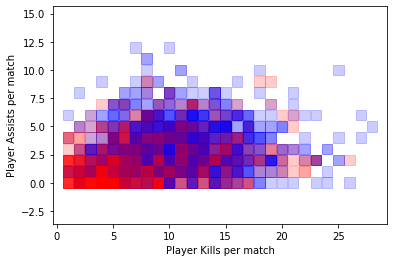

In [27]:
col = np.where(df.standing==0,'b','r')
plt.scatter(df.kills, df.assists,  color=col, alpha=0.2,s = 110, marker = 's')
plt.axis('equal')
plt.xlabel("Player Kills per match")
plt.ylabel("Player Assists per match")
plt.show()

Now, let's look at the per minute data

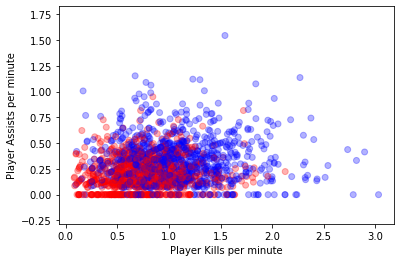

In [28]:
plt.scatter(minutes_df.kills, minutes_df.assists,  color=col, alpha=0.3)
plt.xlabel("Player Kills per minute")
plt.ylabel("Player Assists per minute")
plt.axis('equal')
plt.show()

## Create and Test Both Models

In [30]:
X = np.asarray(df[['kills','deaths','assists']])
X_min = np.asarray(minutes_df[['kills','deaths','assists']])
y = np.asarray(df['standing'])

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
X_train_min, X_test_min, y_train, y_test = train_test_split( X_min, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1500, 3) (1500,)
Test set: (376, 3) (376,)


Now, we need to create and train our models

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
model = LogisticRegression(C=0.05, solver='liblinear').fit(X_train,y_train)
minute_model = LogisticRegression(C=0.18, solver='liblinear').fit(X_train_min,y_train)

Now, we can create two lists with predicted outcome and probability of outcome

In [49]:
yhat = model.predict(X_test)
yhat_prob = model.predict_proba(X_test)

yhat_min = minute_model.predict(X_test_min)
yhat_prob_min = minute_model.predict_proba(X_test_min)

Let's check the Jaccard index for accuracy

In [50]:
from sklearn.metrics import jaccard_score
print(f'Jaccard for per game: {jaccard_score(y_test, yhat)}')
print(f'Jaccard for per minute: {jaccard_score(y_test, yhat_min)}')

Jaccard for per game: 0.6832579185520362
Jaccard for per minute: 0.6666666666666666


In [51]:
from sklearn.metrics import log_loss

# calculate log loss
print(f'Log Loss for per game: {log_loss(y_test, yhat_prob)}')
print(f'Log Loss for per minute: {log_loss(y_test, yhat_prob_min)}')

Log Loss for per game: 0.4271724397243174
Log Loss for per minute: 0.4250179154135514


In [52]:
from sklearn.metrics import classification_report
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.85      0.78      0.82       198
           1       0.78      0.85      0.81       178

    accuracy                           0.81       376
   macro avg       0.81      0.82      0.81       376
weighted avg       0.82      0.81      0.81       376



In [53]:
from sklearn.metrics import classification_report
print (classification_report(y_test, yhat_min))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       198
           1       0.79      0.81      0.80       178

    accuracy                           0.81       376
   macro avg       0.81      0.81      0.81       376
weighted avg       0.81      0.81      0.81       376



In [54]:
cdf = pd.concat([pd.DataFrame(['kills','deaths','assists']),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
print(cdf)

         0         0
0    kills -0.211924
1   deaths  0.397177
2  assists -0.408574


In [55]:
cdf = pd.concat([pd.DataFrame(['kills','deaths','assists']),pd.DataFrame(np.transpose(minute_model.coef_))], axis = 1)
print(cdf)

         0         0
0    kills -1.671688
1   deaths  3.499760
2  assists -2.208698


In [56]:
from sklearn.metrics import f1_score
print(f1_score(y_test, yhat))

0.8118279569892473
